In [5]:
# for folders one level below the heirarchy
import sys
import os
current_dir = os.getcwd()
parent_dir = os.path.abspath(os.path.join(current_dir, os.pardir))
sys.path.append(parent_dir)

## More dependencies
import scipy.fft as spfft
from scipy.ndimage import gaussian_filter1d as sp_gaussian_filter1d
from scipy.ndimage import affine_transform as sp_affine_transform
from scipy.ndimage import gaussian_filter as sp_gaussian_filter
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from itertools import product

cupyon=True

try:
    import cupy as cp
    import numpy as np
    import cupyx.scipy.fft as cpfft
    import cupyx.scipy.ndimage
    from cupyx.scipy.ndimage import gaussian_filter1d as cp_gaussian_filter1d
    from cupyx.scipy.ndimage import gaussian_filter as cp_gaussian_filter
    from cupyx.scipy.ndimage import affine_transform as cp_affine_transform
except ImportError:
    cp = np
    cpfft = spfft
    cp_gaussian_filter1d = sp_gaussian_filter1d
    cp_gaussian_filter = sp_gaussian_filter
    cp_affine_transform = sp_affine_transform
    cupyon = False
    print("cupy not installed. Using numpy.")


In [2]:
## Global Variables
# Hardware-defined Constants
aodaperture = 7.5e-3 # Aperture size of the AOD
soundvelocity = 650   # Sound velocity in the medium
cycletime = aodaperture / soundvelocity  # Time for one cycle of the waveform

focallength = 9.1 * 10**(-3) # mm
wavelength = 630 * 10**(-9)

print("Cycletime in nanoseconds: ", cycletime * 1e9)

# Simulation Constants
numpix_frame = 1000
numpix_real = 4096
pixelsize_real = aodaperture / numpix_frame
aperturesize_real = numpix_real * pixelsize_real
aperturesize_fourier = wavelength * focallength / (pixelsize_real)
pixelsize_fourier = aperturesize_fourier / numpix_real
print("Aod pixel pitch in microns: ", pixelsize_real*1e6)
print("Fourier space spacing in microns: ", pixelsize_fourier*10**6)

# Adjustable Variables
movementtime = 100*10**(-6) # Time for the movement of the AOD
startlocation = 60*10**(-6) # Start location of the AOD in microns. 0 is set to the center of Fourier space.
endlocation = 260*10**(-6) # End location of the AOD in microns

polynomialbasis = 'Chebyshev'  # Basis for the polynomial fit
numcoefficients = 100

globalvariables = [aodaperture, soundvelocity, cycletime, focallength, wavelength, numpix_frame, numpix_real, pixelsize_real, aperturesize_real, aperturesize_fourier, pixelsize_fourier, movementtime, startlocation, endlocation, polynomialbasis, numcoefficients]
aodaperture, soundvelocity, cycletime, focallength, wavelength, numpix_frame, numpix_real, pixelsize_real, aperturesize_real, aperturesize_fourier, pixelsize_fourier, movementtime, startlocation, endlocation, polynomialbasis, numcoefficients = globalvariables

### From the global variables, initialize the AWG waveform
numpix_waveform = int(movementtime / cycletime * numpix_frame)
AWGwaveform = cp.zeros(numpix_waveform)
print(len(AWGwaveform))



Cycletime in nanoseconds:  11538.461538461537
Aod pixel pitch in microns:  7.499999999999999
Fourier space spacing in microns:  0.18662109375000002
8666


In [19]:
def initpath_linearramp(globalvariables):
    '''Initializes positions throughout the movementtime with an acceleration profile that is a linear ramp up for half the time then down for half the time that moves
    the atom from startlocation to endlocation.'''
    aodaperture, soundvelocity, cycletime, focallength, wavelength, numpix_frame, numpix_real, pixelsize_real, aperturesize_real, aperturesize_fourier, pixelsize_fourier, movementtime, startlocation, endlocation, polynomialbasis, numcoefficients = globalvariables
    
    
    
    return test

def initpath_minimizejerk(globalvariables):
    '''Initializes positions throughout the movementtime that minimizes jerk.'''
    aodaperture, soundvelocity, cycletime, focallength, wavelength, numpix_frame, numpix_real, pixelsize_real, aperturesize_real, aperturesize_fourier, pixelsize_fourier, movementtime, startlocation, endlocation, polynomialbasis, numcoefficients = globalvariables

    # Define the number of time steps and total time
    num_steps = 1000
    total_time = movementtime  # You may need to adjust this based on the problem's requirements
    time = np.linspace(0, 1, num_steps)
    time_out = np.linspace(0, total_time, num_steps)
    # Initial and final conditions
    initial_position = startlocation*10**6
    final_position = endlocation*10**6
    D = final_position - initial_position

    # Function to calculate velocity and position from acceleration
    def integrate_acceleration(acceleration, dt):
        velocity = np.cumsum(acceleration) * dt
        position = np.cumsum(velocity) * dt
        return velocity, position

    # Function to calculate jerk from acceleration
    def calculate_jerk(acceleration, dt):
        jerk = np.gradient(acceleration, dt)
        return jerk

    # Objective function to minimize jerk and achieve target position
    def objective(acceleration, dt):
        velocity, position = integrate_acceleration(acceleration, dt)
        jerk = calculate_jerk(acceleration, dt)
        jerk_cost = np.sum(jerk**2)  # Minimize the squared jerk
        position_error = (position[-1] - D)**2  # Ensure final position is D
        velocity_error = velocity[-1]**2  # Ensure final velocity is 0
        return jerk_cost + position_error + velocity_error

    # Initial guess for the acceleration profile
    initial_guess = np.zeros(num_steps)

    # Optimization constraints
    constraints = [
        {'type': 'eq', 'fun': lambda a: integrate_acceleration(a, time[1] - time[0])[1][-1] - D},  # Final position constraint
        {'type': 'eq', 'fun': lambda a: integrate_acceleration(a, time[1] - time[0])[0][-1]},     # Final velocity constraint
    ]

    # Perform the optimization
    result = minimize(objective, initial_guess, args=(time[1] - time[0]), constraints=constraints, method='SLSQP')

    # Extract the optimized acceleration profile
    optimized_acceleration = result.x
    optimized_velocity, optimized_position = integrate_acceleration(optimized_acceleration, time[1] - time[0])
    optimized_jerk = calculate_jerk(optimized_acceleration, time[1] - time[0])
    
    optimized_acceleration = optimized_acceleration / 10**6
    optimized_velocity = optimized_velocity / 10**6
    optimized_position = optimized_position / 10**6
    optimized_jerk = optimized_jerk / 10**6
    
    optimized_position = optimized_position + initial_position

    return optimized_position, optimized_velocity, optimized_acceleration, optimized_jerk, time_out

In [20]:
optimized_position, optimized_velocity, optimized_acceleration, optimized_jerk, time = initpath_minimizejerk(globalvariables)

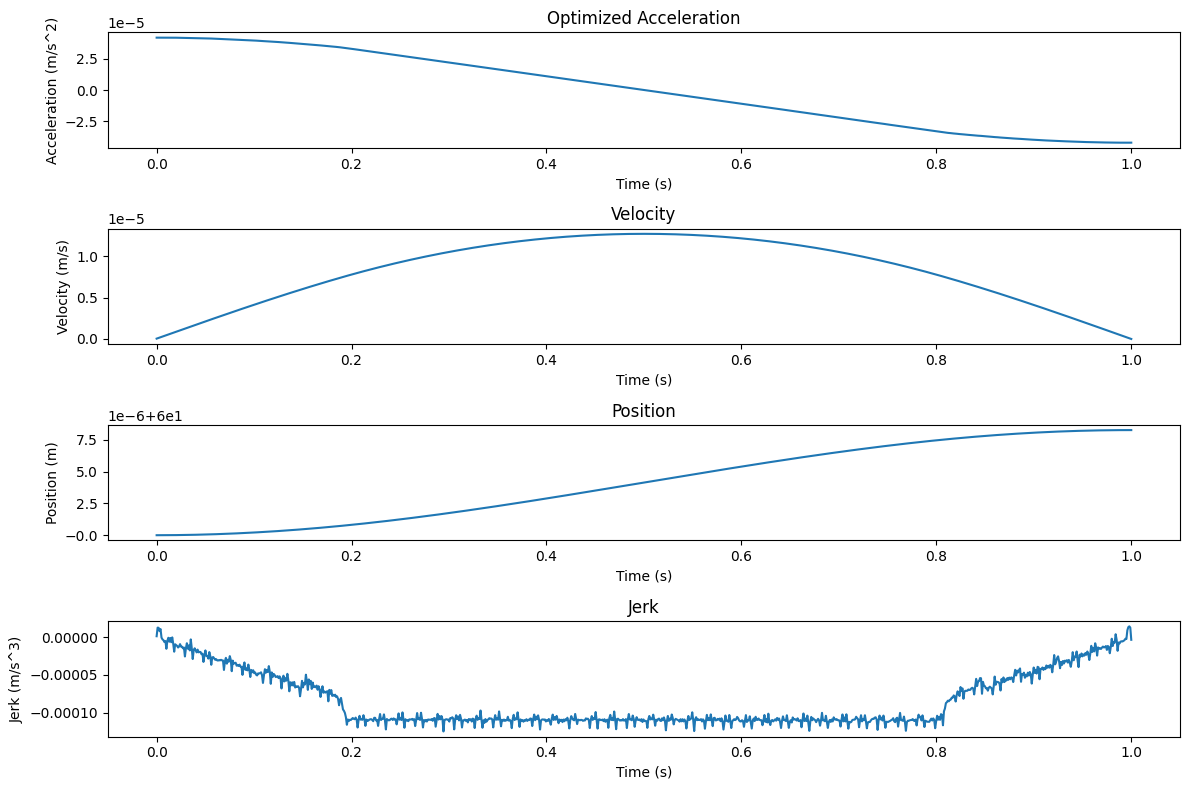

In [21]:
plt.figure(figsize=(12, 8))

plt.subplot(4, 1, 1)
plt.plot(time, optimized_acceleration)
plt.title('Optimized Acceleration')
plt.xlabel('Time (s)')
plt.ylabel('Acceleration (m/s^2)')

plt.subplot(4, 1, 2)
plt.plot(time, optimized_velocity)
plt.title('Velocity')
plt.xlabel('Time (s)')
plt.ylabel('Velocity (m/s)')

plt.subplot(4, 1, 3)
plt.plot(time, optimized_position)
plt.title('Position')
plt.xlabel('Time (s)')
plt.ylabel('Position (m)')

plt.subplot(4, 1, 4)
plt.plot(time, optimized_jerk)
plt.title('Jerk')
plt.xlabel('Time (s)')
plt.ylabel('Jerk (m/s^3)')

plt.tight_layout()
plt.show()